<a href="https://colab.research.google.com/github/mneochengrustno/Works/blob/main/CV_Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

file_path1 = '/content/im1.jpg'
file_path2 = '/content/im2.jpg'

def load_images(image_path1, image_path2):
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)
    return img1, img2

# препроцессинг (шумоподавление, гамма-коррекция)
def preprocess_images(img1, img2):
    def denoise_and_correct(img):
        img_denoised = cv2.GaussianBlur(img, (5, 5), 0)  # шумоподавление
        img_ycrcb = cv2.cvtColor(img_denoised, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(img_ycrcb)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        y = clahe.apply(y)
        img_clahe = cv2.merge([y, cr, cb])
        img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_YCrCb2BGR)

        #гамма-коррекция
        gamma = 1.2
        img_gamma_corrected = np.power(img / 255.0, gamma) * 255
        img_gamma_corrected = np.clip(img_gamma_corrected, 0, 255).astype(np.uint8)

        return img_gamma_corrected

    img1_processed = denoise_and_correct(img1)
    img2_processed = denoise_and_correct(img2)
    return img1_processed, img2_processed

# обнаружение линий и углов
def detect_lines_and_corners(image):
    processed_image = cv2.GaussianBlur(image, (5, 5), 0)
    edges = cv2.Canny(processed_image, 30, 100, apertureSize=3) # понижены пороги

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, minLineLength=30, maxLineGap=10)

    horizontal_lines = []
    vertical_lines = []

    image_copy = image.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y2 - y1) < 10:
            horizontal_lines.append((x1, y1, x2, y2))
        elif abs(x2 - x1) < 10:
            vertical_lines.append((x1, y1, x2, y2))
        cv2.line(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2) # линии для отладки
    plt.figure(figsize=(15, 8))

    # исходное изображение
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    # изображение с найденными линиями
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.title("Detected Lines")
    plt.axis('off')
    plt.show()
    corners = []
    for x1, y1, x2, y2 in horizontal_lines:
        for x3, y3, x4, y4 in vertical_lines:
            if x1 <= x3 <= x2 and y3 <= y1 <= y4:
                corners.append((x3, y1))
    return corners, horizontal_lines, vertical_lines

# построение гистограмм
def plot_histogram(img, title="Histogram"):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.hist(gray.ravel(), bins=256, range=[0,256])
    plt.title(title)
    plt.show()

# визуализация гистограмм и изображений
def visualize_images_and_histograms(img1, img2, img1_processed, img2_processed):
    plt.figure(figsize=(15, 8))
    # изображения до препроцессинга
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.title("Original Image 1")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.title("Original Image 2")
    plt.axis('off')

    # изображения после препроцессинга
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(img1_processed, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image 1")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(img2_processed, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image 2")
    plt.axis('off')

    plt.show()

    # гистограммы
    plot_histogram(img1, "Histogram of Image 1")
    plot_histogram(img2, "Histogram of Image 2")
    plot_histogram(img1_processed, "Histogram of Processed Image 1")
    plot_histogram(img2_processed, "Histogram of Processed Image 2")

In [ ]:
# калибровка камеры
def calibrate_camera(corners, image_size):
    obj_points = np.zeros((len(corners), 3), np.float32)
    obj_points[:, :2] = np.array(corners)
    img_points = np.array(corners, dtype=np.float32).reshape(-1, 1, 2)
    ret, camera_matrix, dist_coeffs, _, _ = cv2.calibrateCamera(
        [obj_points], [img_points], image_size, None, None
    )
    return camera_matrix, dist_coeffs
# коррекция геометрических искажений
def undistort_images(img1, img2, camera_matrix, dist_coeffs):
    img1_undistorted = cv2.undistort(img1, camera_matrix, dist_coeffs, None)
    img2_undistorted = cv2.undistort(img2, camera_matrix, dist_coeffs, None)
    return img1_undistorted, img2_undistorted

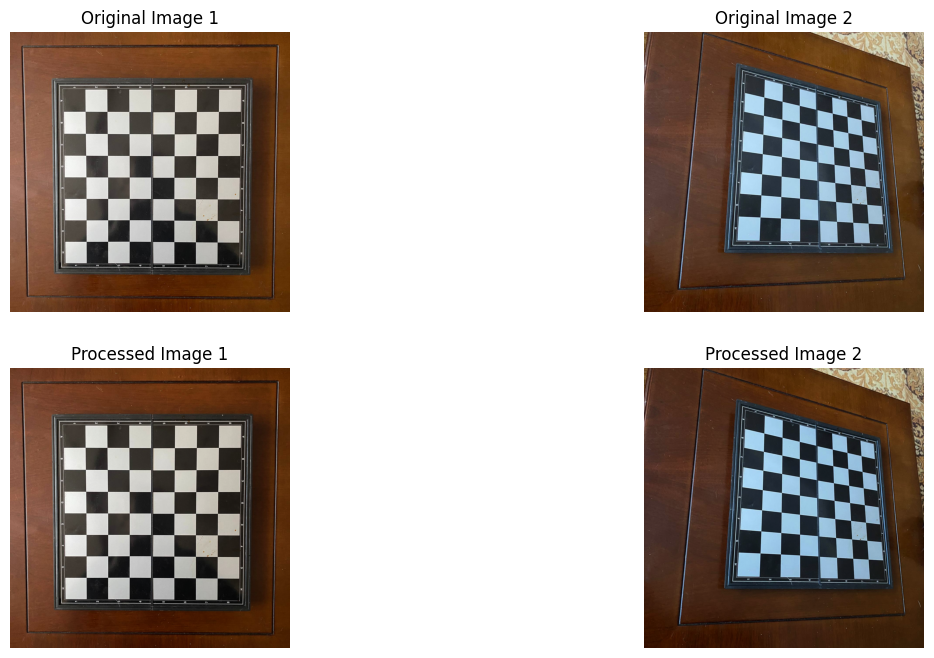

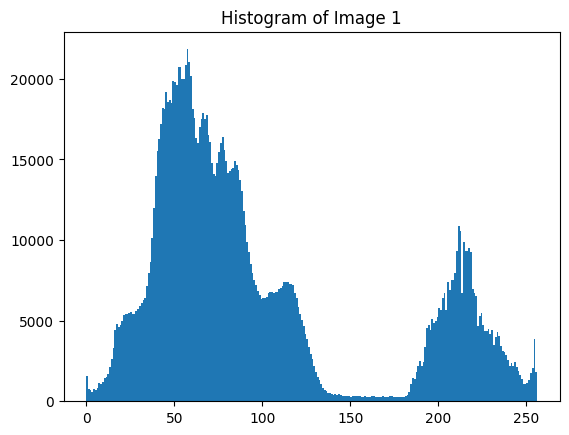

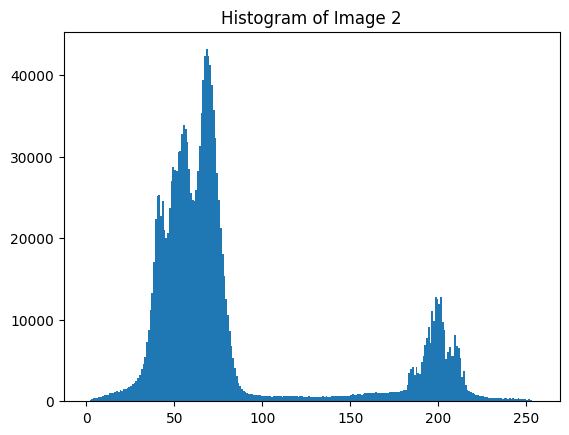

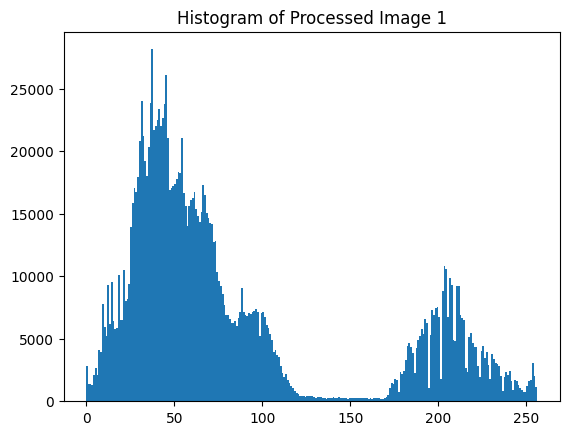

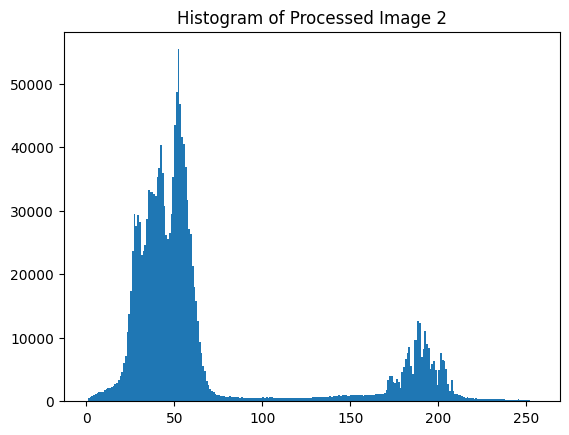

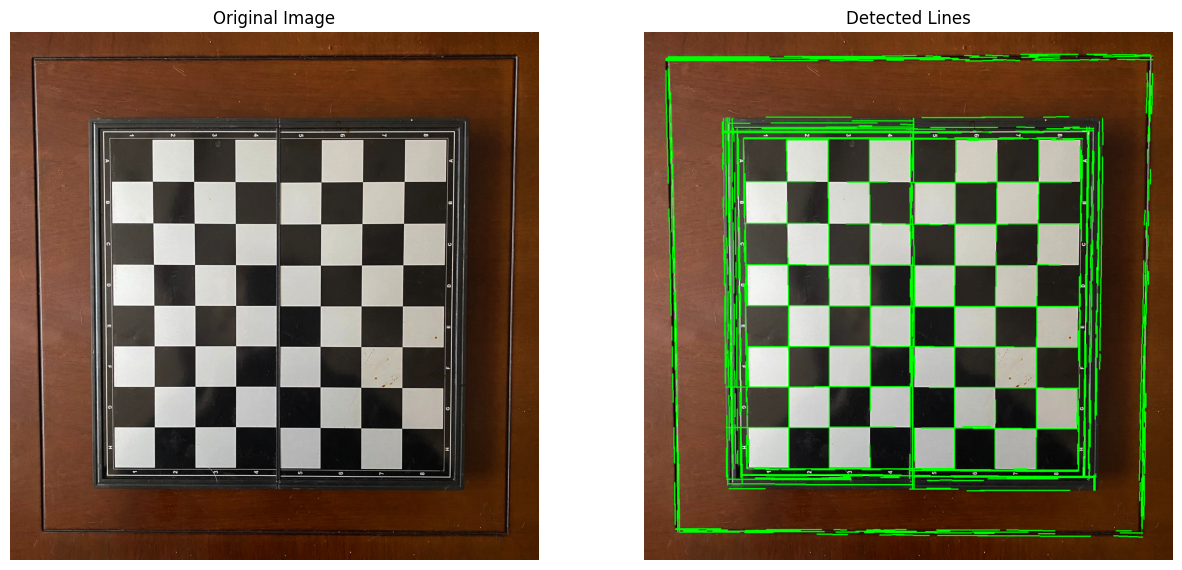

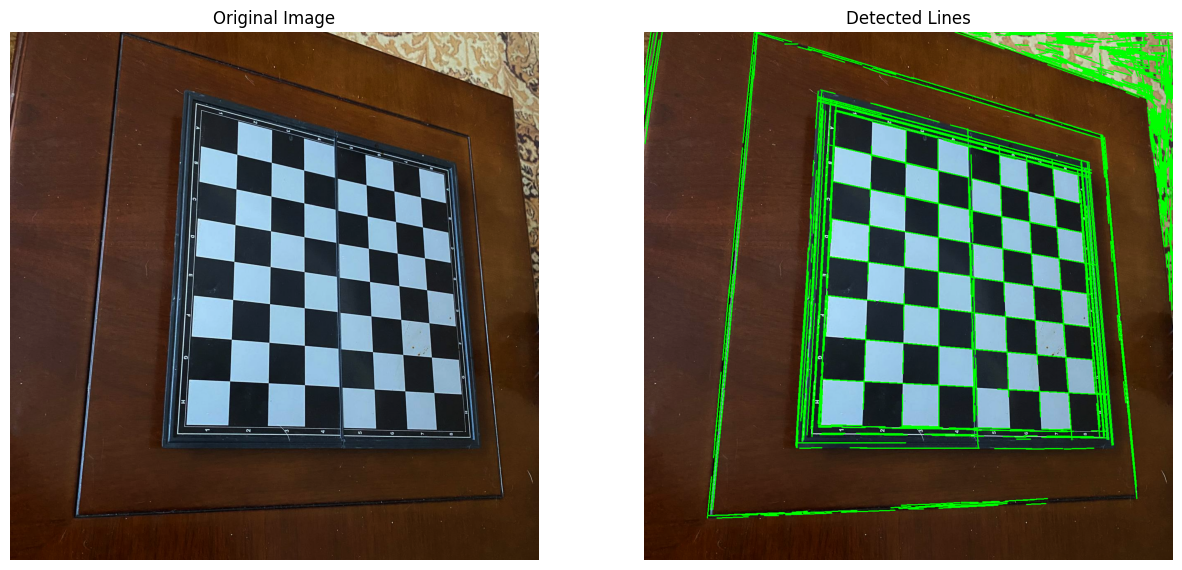

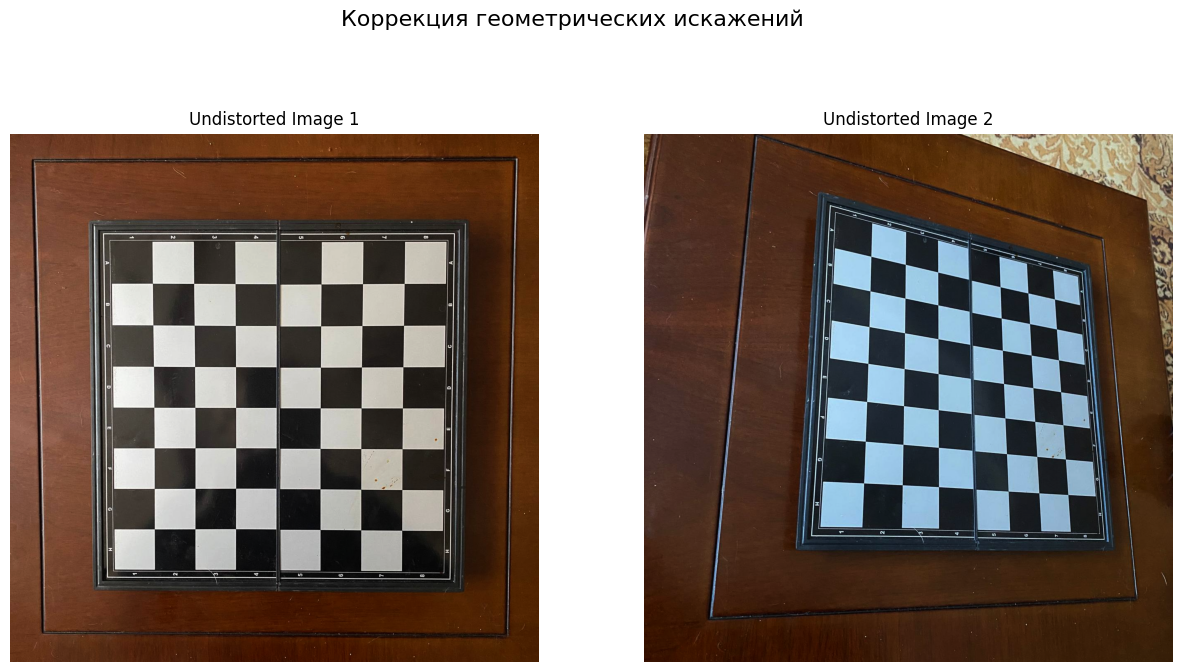

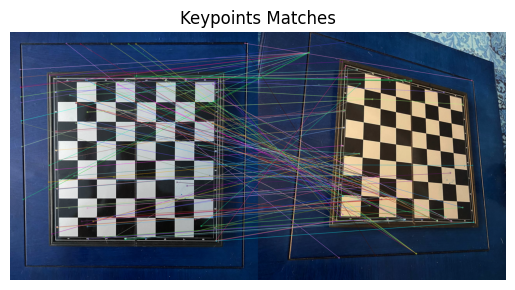

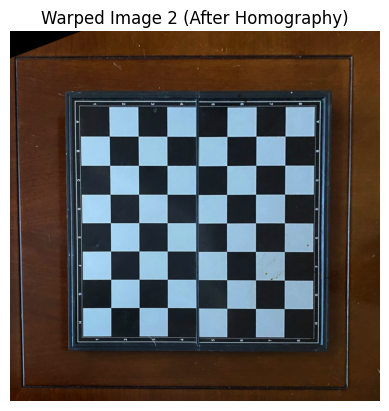

In [ ]:
# функция для поиска и сопоставления точек
def find_and_match_keypoints(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    # сопоставление
    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    matches = np.asarray(matches)
    # фильтрация
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    # визуализация сопоставлений
    result_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(result_img)
    plt.title("Keypoints Matches")
    plt.axis('off')
    plt.show()
    return kp1, kp2, good_matches

# гомография
def find_homography_and_warp(img1, img2, kp1, kp2, good_matches):
    if len(good_matches) > 4:
        src_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        height, width, _ = img1.shape
        img_warped = cv2.warpPerspective(img2, H, (width, height))
        plt.imshow(cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB))
        plt.title("Warped Image 2 (After Homography)")
        plt.axis('off')
        plt.show()
    else:
        print("Недостаточно совпадений для вычисления гомографии")

img1, img2 = load_images(file_path1, file_path2)
img1_pr, img2_pr = preprocess_images(img1, img2)
visualize_images_and_histograms(img1, img2, img1_pr, img2_pr)
corners1, horizontal_lines1, vertical_lines1 = detect_lines_and_corners(img1_pr)
corners2, horizontal_lines2, vertical_lines2 = detect_lines_and_corners(img2_pr)
image_size = img1.shape[:2][::-1]
camera_matrix, dist_coeffs = calibrate_camera(corners1, image_size)
img1_undistorted, img2_undistorted = undistort_images(img1_pr, img2_pr, camera_matrix, dist_coeffs)
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_undistorted, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image 1")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_undistorted, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image 2")
plt.axis('off')
plt.suptitle("Коррекция геометрических искажений", fontsize=16)
plt.show()
kp1, kp2, good_matches = find_and_match_keypoints(img1_pr, img2_pr)
find_homography_and_warp(img1_pr, img2_pr, kp1, kp2, good_matches)